In [1]:
models = []

## Modules and data preparation

In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import *
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
from pandas import DataFrame

def data_normalization(df: DataFrame, days_range: int=24, include_cur_row: bool=False):
    '''
    Return the normalized data:
    + df: the dataframe to be normalized
    + range: the number of previous rows (or including the current row) to be considered in the normalization
    + include_cur_row: True if we consider the current row in the normalization process (calculate mean and std
    using the current row and (range-1) previous rows), False if we want to use all the passed data for normalization 
    processing ((calculate mean and std using (range) previous rows))
    '''
    
    df_roll = None

    if include_cur_row == False:
        df_roll = df.rolling(days_range, closed='left')
    else:
        df_roll = df.rolling(days_range)
        
    res_df = (df - df_roll.mean()) / df_roll.std()
    res_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return res_df[days_range:] #

In [4]:
df = pd.read_csv("../../data/test.csv")

## LightGBM classification

In [5]:
import lightgbm as lgb

path = "../../data/norm_features_test.csv" #data_1h_with_features_ver02
df = pd.read_csv(path) 
df["label"] = np.vectorize(int)(df["close"] - df["close"].shift(1) >= 0)

# if path == "../../data/data_1h_with_features_ver01.csv": #test
#     days_ranges = [4,8,12,16,20,24,36,48,72]
#     price_types = ["close", "high", "low", "open"]
#     features = ["SMA", "EMA", "WMA", "RSI", "HMA", "TEMA", "DEMA"]

#     df.drop(columns=["time_open"], inplace=True)

#     for i in range(len(days_ranges)-1):
#         for j in range(i+1, len(days_ranges)):
#             for price_type in price_types:
#                 for feature in features:
#                     new_col_name = "diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])
#                     numerator_col_name = price_type+"_"+feature+str(days_ranges[i])
#                     denominator_col_name = price_type+"_"+feature+str(days_ranges[j])
#                     df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])


#     for days_range in days_ranges:
#         for price_type1 in price_types:
#             for price_type2 in price_types:
#                 for feature in features:
#                     new_col_name = "diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)
#                     numerator_col_name = price_type1
#                     denominator_col_name = price_type2+"_"+feature+str(days_range)
#                     df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])


    # for feature in ["CCI", "BOP", "ADX", "ATR", "MFI"]:
    #     for i in range(len(days_ranges)-1): 
    #         for j in range(i+1, len(days_ranges)):
    #             new_col_name = "diff_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])
    #             numerator_col_name = feature+str(days_ranges[i])
    #             denominator_col_name = feature+str(days_ranges[j])
    #             df[new_col_name] = df[numerator_col_name]/df[denominator_col_name]-1


#     for i in range(1,5):
#         a = df[["VWAP","volume", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]].shift(i)
#         a.columns += str(i)
#         df = pd.concat((df, a), axis=1)
#         for price_type1 in price_types:
#             for price_type2 in price_types:
#                 new_col_name = "diff_cur_" + price_type1 + "_price-" + price_type2 + "_price_" + str(i) + "_ago"
#                 numerator_col_name = price_type1
#                 denominator_col_name = price_type2
#                 df[new_col_name] =  np.log(df[numerator_col_name]/df[denominator_col_name].shift(i))


df.dropna(inplace=True)

In [6]:
# import lightgbm as lgb

# path = "../../data/data_1h_with_features_ver01.csv" #data_1h_with_features_ver02
# df = pd.read_csv(path) 
# df["label"] = np.vectorize(int)(df["close"] - df["close"].shift(1) >= 0)
# df.drop(columns=["time_open"], inplace=True)

In [7]:
if path == "../../data/data_1h_with_features_ver02.csv":
    days_ranges = [4,8,12,16,20,24,36,48,72]
    price_types = ["close", "high", "low", "open"]
    features = ["price_SMA", "price_EMA", "price_WMA", "RSI"]

    for i in range(len(days_ranges)-1):
        for j in range(i+1, len(days_ranges)):
            for price_type in price_types:
                for feature in features:
                    new_col_name = "diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])
                    numerator_col_name = price_type+"_"+feature+str(days_ranges[i])
                    denominator_col_name = price_type+"_"+feature+str(days_ranges[j])
                    df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])


    for days_range in days_ranges:
        for price_type1 in price_types:
            for price_type2 in price_types:
                for feature in features:
                    new_col_name = "diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)
                    numerator_col_name = price_type1
                    denominator_col_name = price_type2+"_"+feature+str(days_range)
                    df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])


    for feature in ["CCI", "BOP", "ADX", "ATR", "MFI"]:
        for i in range(len(days_ranges)-1): 
            for j in range(i+1, len(days_ranges)):
                new_col_name = "diff_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])
                numerator_col_name = feature+str(days_ranges[i])
                denominator_col_name = feature+str(days_ranges[j])
                df[new_col_name] = df[numerator_col_name]/df[denominator_col_name]-1


    for i in range(1,5):
        a = df[["volume", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]].shift(i)
        a.columns += str(i)
        df = pd.concat((df, a), axis=1)
        for price_type1 in price_types:
            for price_type2 in price_types:
                new_col_name = "diff_cur_" + price_type1 + "_price-" + price_type2 + "_price_" + str(i) + "_ago"
                numerator_col_name = price_type1
                denominator_col_name = price_type2
                df[new_col_name] =  np.log(df[numerator_col_name]/df[denominator_col_name].shift(i))
        

In [8]:
df.ffill(inplace=True)
df.dropna(inplace=True)

In [9]:
# if path != "../../data/data_1h_with_features_ver02.csv":
#     df.drop(columns=['KST', 'MACD', 'VTX12', 'VTX16', 'VTX20', 'VTX24', 'VTX36', 'VTX4',
#            'VTX48', 'VTX72', 'VTX8', 'VTX96', "Unnamed: 0"], inplace=True)

In [10]:
# ori_df = df.copy()
# ori_df.head(2)

In [11]:
# Consider only diff columns
# if True:
#     diff_columns = []

#     for col in df.columns:
#         if "label" in col or ("diff" in col and "MA" in col):
#             diff_columns.append(col)

#     df = df[diff_columns]
    
# df.drop(columns=["close_price_diff", "high_price_diff", "low_price_diff", "open_price_diff"], inplace=True)

In [12]:
###
# for i in [4,8,12,16,20,24,36,48,72,96]:
#     df.drop(columns = "VTX"+str(i), inplace=True)
###

In [13]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [17]:
df.reset_index(drop=True, inplace=True)

X = df.drop(columns=["label"])[:-1]
y = df["label"].shift(0)[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

i = 24

diff_col = []

for c in X_train.columns:
    if "diff" in c:
        diff_col.append(c)
        
diff_col = []
for c in X_train.columns:
    if "diff" in c:
        diff_col.append(c)
        
# X_train = data_normalization(X_train, days_range=i)
# X_val = data_normalization(X_val, days_range=i)
# X_test = data_normalization(X_test, days_range=i)
# X_train.loc[i:, ~X_train.columns.isin(diff_col)] = data_normalization(X_train.loc[:, ~X_train.columns.isin(diff_col)])
# X_val.loc[i:, ~X_val.columns.isin(diff_col)] = data_normalization(X_val.loc[:, ~X_val.columns.isin(diff_col)])
# X_test.loc[i:, ~X_test.columns.isin(diff_col)] = data_normalization(X_test.loc[:, ~X_test.columns.isin(diff_col)])

# X_train = X_train
# X_val = X_val
# X_test = X_test

# y_train = y_train[i:]
# y_val = y_val[i:]
# y_test = y_test[i:]

depth = 3
rate = 0.2
lr = 0.02

train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_val, y_val, reference=train_data)

params = {'objective': 'binary',
                      'metric': ['auc'],
                      'boosting':'gbdt',
                      'num_boost_round':1000,
                      'early_stopping_round':300,
                      'learning_rate': lr,
                      'max_depth': depth,
#                       'n_jobs': -1,
#                       'min_data_in_leaf': int(df.shape[0]*0.01),
                      'num_leaves': 2**depth-1,
#                       'feature_fraction': rate,
#                       'extra_trees': True,
                      'verbosity': 1}

print(params)

model = lgb.train(params, train_data,                     
                  valid_sets=[train_data, valid_data],
                  valid_names=['train', 'valid'])

predicted_y = model.predict(X_test).reshape(-1,1)
target_y = y_test.to_numpy().reshape(-1,1)

transformed_predicted_y = Binarizer(threshold=0.5).fit_transform(predicted_y)

print(classification_report(target_y, transformed_predicted_y))
print("Confusion matrix:\n", confusion_matrix(target_y, transformed_predicted_y))

acc = accuracy_score(target_y, transformed_predicted_y)
print("Accuracy:", acc)

models.append(model)

{'objective': 'binary', 'metric': ['auc'], 'boosting': 'gbdt', 'num_boost_round': 1000, 'early_stopping_round': 300, 'learning_rate': 0.02, 'max_depth': 3, 'num_leaves': 7, 'verbosity': 1}


/home/hoangvictor/Installations/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 13348, number of negative: 13169
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267495
[LightGBM] [Info] Number of data points in the train set: 26517, number of used features: 1049
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503375 -> initscore=0.013501
[LightGBM] [Info] Start training from score 0.013501
[1]	train's auc: 0.958064	valid's auc: 0.95868
Training until validation scores don't improve for 300 rounds
[2]	train's auc: 0.96879	valid's auc: 0.971659
[3]	train's auc: 0.970264	valid's auc: 0.972652
[4]	train's auc: 0.971989	valid's auc: 0.975508
[5]	train's auc: 0.974688	valid's auc: 0.978143
[6]	train's auc: 0.977114	valid's auc: 0.980462
[7]	train's auc: 0.977911	valid's auc: 0.981285
[8]	train's auc: 0.978991	valid's auc: 0.981915
[9]	train's auc: 0.978703	valid's auc: 0.981765
[10]	trai

[161]	train's auc: 0.994092	valid's auc: 0.996147
[162]	train's auc: 0.994108	valid's auc: 0.996149
[163]	train's auc: 0.994128	valid's auc: 0.996161
[164]	train's auc: 0.994165	valid's auc: 0.996194
[165]	train's auc: 0.994175	valid's auc: 0.996198
[166]	train's auc: 0.9942	valid's auc: 0.996223
[167]	train's auc: 0.994232	valid's auc: 0.996249
[168]	train's auc: 0.99425	valid's auc: 0.996257
[169]	train's auc: 0.994264	valid's auc: 0.996264
[170]	train's auc: 0.994296	valid's auc: 0.99629
[171]	train's auc: 0.994307	valid's auc: 0.996298
[172]	train's auc: 0.994341	valid's auc: 0.996323
[173]	train's auc: 0.994358	valid's auc: 0.996338
[174]	train's auc: 0.994374	valid's auc: 0.996359
[175]	train's auc: 0.994394	valid's auc: 0.996373
[176]	train's auc: 0.99441	valid's auc: 0.996381
[177]	train's auc: 0.99444	valid's auc: 0.996406
[178]	train's auc: 0.994463	valid's auc: 0.996418
[179]	train's auc: 0.994484	valid's auc: 0.996434
[180]	train's auc: 0.994496	valid's auc: 0.996442
[181]	

[340]	train's auc: 0.99634	valid's auc: 0.9976
[341]	train's auc: 0.996345	valid's auc: 0.997604
[342]	train's auc: 0.996355	valid's auc: 0.997602
[343]	train's auc: 0.996365	valid's auc: 0.997608
[344]	train's auc: 0.996374	valid's auc: 0.997611
[345]	train's auc: 0.996388	valid's auc: 0.997621
[346]	train's auc: 0.996393	valid's auc: 0.997619
[347]	train's auc: 0.996404	valid's auc: 0.997624
[348]	train's auc: 0.996413	valid's auc: 0.997628
[349]	train's auc: 0.996422	valid's auc: 0.997633
[350]	train's auc: 0.996425	valid's auc: 0.997634
[351]	train's auc: 0.996433	valid's auc: 0.997637
[352]	train's auc: 0.996439	valid's auc: 0.997642
[353]	train's auc: 0.996448	valid's auc: 0.997647
[354]	train's auc: 0.996457	valid's auc: 0.997648
[355]	train's auc: 0.996461	valid's auc: 0.997648
[356]	train's auc: 0.996471	valid's auc: 0.997658
[357]	train's auc: 0.996476	valid's auc: 0.997662
[358]	train's auc: 0.996485	valid's auc: 0.997667
[359]	train's auc: 0.996498	valid's auc: 0.997675
[36

[506]	train's auc: 0.997379	valid's auc: 0.998044
[507]	train's auc: 0.997383	valid's auc: 0.998047
[508]	train's auc: 0.997387	valid's auc: 0.998049
[509]	train's auc: 0.997393	valid's auc: 0.998053
[510]	train's auc: 0.997403	valid's auc: 0.998058
[511]	train's auc: 0.997406	valid's auc: 0.998059
[512]	train's auc: 0.997411	valid's auc: 0.998062
[513]	train's auc: 0.997417	valid's auc: 0.998063
[514]	train's auc: 0.997425	valid's auc: 0.998069
[515]	train's auc: 0.997428	valid's auc: 0.99807
[516]	train's auc: 0.997433	valid's auc: 0.998072
[517]	train's auc: 0.997438	valid's auc: 0.998073
[518]	train's auc: 0.99744	valid's auc: 0.998072
[519]	train's auc: 0.997443	valid's auc: 0.998074
[520]	train's auc: 0.997449	valid's auc: 0.998073
[521]	train's auc: 0.997453	valid's auc: 0.998074
[522]	train's auc: 0.997456	valid's auc: 0.998077
[523]	train's auc: 0.997457	valid's auc: 0.998076
[524]	train's auc: 0.997461	valid's auc: 0.998077
[525]	train's auc: 0.997466	valid's auc: 0.998078
[5

[683]	train's auc: 0.99808	valid's auc: 0.998277
[684]	train's auc: 0.998082	valid's auc: 0.998279
[685]	train's auc: 0.998085	valid's auc: 0.998279
[686]	train's auc: 0.998087	valid's auc: 0.998279
[687]	train's auc: 0.99809	valid's auc: 0.998279
[688]	train's auc: 0.998093	valid's auc: 0.99828
[689]	train's auc: 0.998096	valid's auc: 0.998281
[690]	train's auc: 0.998099	valid's auc: 0.99828
[691]	train's auc: 0.9981	valid's auc: 0.998282
[692]	train's auc: 0.998103	valid's auc: 0.998284
[693]	train's auc: 0.998104	valid's auc: 0.998283
[694]	train's auc: 0.99811	valid's auc: 0.998284
[695]	train's auc: 0.998112	valid's auc: 0.998285
[696]	train's auc: 0.998115	valid's auc: 0.998288
[697]	train's auc: 0.998118	valid's auc: 0.998289
[698]	train's auc: 0.998121	valid's auc: 0.998287
[699]	train's auc: 0.998124	valid's auc: 0.998288
[700]	train's auc: 0.998133	valid's auc: 0.998296
[701]	train's auc: 0.998135	valid's auc: 0.998297
[702]	train's auc: 0.998137	valid's auc: 0.998296
[703]	t

[855]	train's auc: 0.998537	valid's auc: 0.99838
[856]	train's auc: 0.998539	valid's auc: 0.998382
[857]	train's auc: 0.998543	valid's auc: 0.998383
[858]	train's auc: 0.998544	valid's auc: 0.998385
[859]	train's auc: 0.998547	valid's auc: 0.998384
[860]	train's auc: 0.998548	valid's auc: 0.998383
[861]	train's auc: 0.998551	valid's auc: 0.998383
[862]	train's auc: 0.998554	valid's auc: 0.998385
[863]	train's auc: 0.998557	valid's auc: 0.998386
[864]	train's auc: 0.99856	valid's auc: 0.998388
[865]	train's auc: 0.998564	valid's auc: 0.99839
[866]	train's auc: 0.998566	valid's auc: 0.998392
[867]	train's auc: 0.998568	valid's auc: 0.998392
[868]	train's auc: 0.99857	valid's auc: 0.99839
[869]	train's auc: 0.998571	valid's auc: 0.99839
[870]	train's auc: 0.998572	valid's auc: 0.99839
[871]	train's auc: 0.998573	valid's auc: 0.998388
[872]	train's auc: 0.998577	valid's auc: 0.998391
[873]	train's auc: 0.99858	valid's auc: 0.998389
[874]	train's auc: 0.998581	valid's auc: 0.99839
[875]	tra

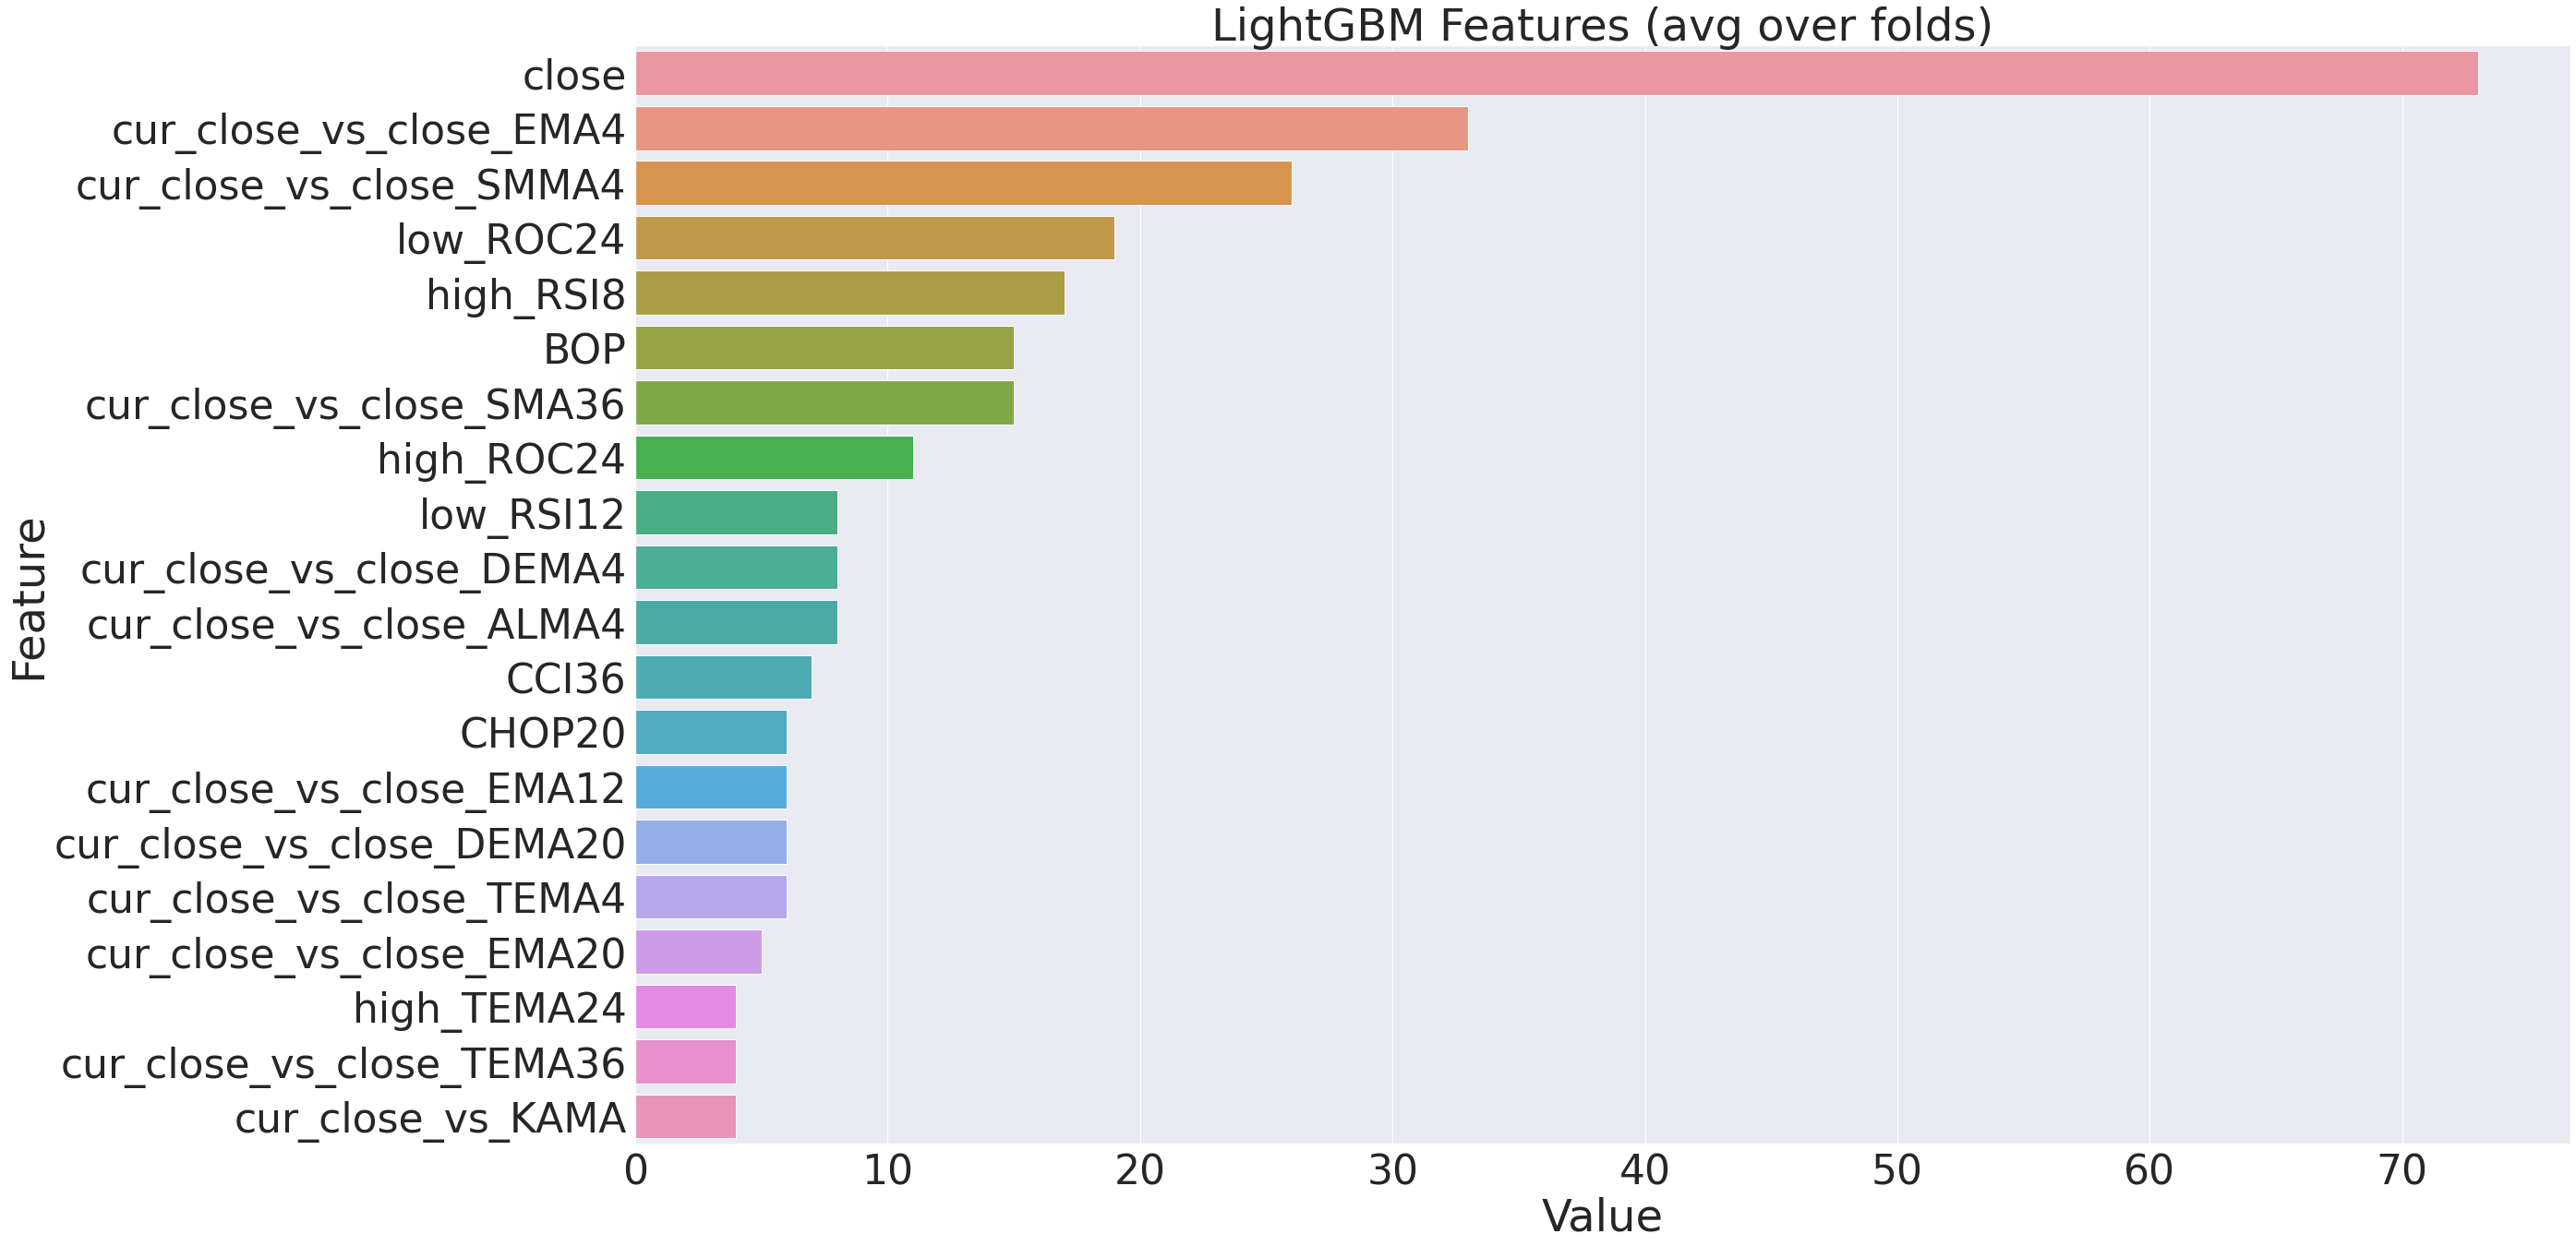

In [15]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 4)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    
plotImp(model, X_test)

In [16]:
a = models[0].predict(X_test) >= 0.5
b = models[1].predict(X_test) >= 0.5
d = models[2].predict(X_test) >= 0.5
e = models[3].predict(X_test) >= 0.5

IndexError: list index out of range

In [ ]:
c = a&b&d&e
true_c = 0
count = 0

for i in range(c.shape[0]):
    if c[i] == True:
        true_c += 1
        if y_test.reset_index(drop=True)[i] == 1:
            count += 1
    else:
        c[i] = -1.0

In [ ]:
print(count, true_c)
count/true_c

In [ ]:
a = models[0].predict(X_test) < 0.5
b = models[1].predict(X_test) < 0.5
d = models[2].predict(X_test) < 0.5
e = models[3].predict(X_test) < 0.5

In [ ]:
c = a&b&d&e
true_c = 0
count = 0

for i in range(c.shape[0]):
    if c[i] == True:
        true_c += 1
        if y_test.reset_index(drop=True)[i] == 0:
            count += 1
    else:
        c[i] = -1.0

In [ ]:
print(count, true_c)
count/true_c

In [ ]:
for c in df.columns:
    print(c)

In [ ]:
plt.hist((df["close"] - df["close"].shift(1))/df["close"], bins=50)

In [ ]:
plt.hist((df["close"] - df["close_price_SMA24"])/df["close_price_SMA24"], bins=50)

In [ ]:
plt.plot((df["open_RS4"]))

In [ ]:
plt.hist(np.log(df["volume"]), bins=50);

In [ ]:
(df["CCI4"]<-120).sum()

In [ ]:
plt.hist(df["BOP8s multiplied by a constant to ensure that most values fall within the standard range of +/- 100."], bins=50)

In [ ]:
df